In [22]:
import time
import copy
import numpy as np
from skimage.filters import gaussian
import cv2 

import matplotlib.pyplot as plt
import pylab as pl

%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)

from tifffile import imread, imsave
import pickle

%reload_ext autoreload
%autoreload 2

from netsurface2d import NetSurf2d
from netsurface2dt import NetSurf2dt
from data3d import Data3d
import bresenham as bham
import bobsegutils as bsu

from shapely import geometry
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

from scipy.interpolate import griddata

from scipy.stats.stats import pearsonr
from scipy.stats.stats import kendalltau

Populating the interactive namespace from numpy and matplotlib


/Users/jug/local/miniconda3/envs/BobSeg/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['griddata', 'copy', 'imread', 'imsave', 'Polygon', 'stack']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [48]:
# filename = '/Users/jug/Repositories/GIT/BobSeg/data/ProjectGoldstein/4MyosinMembraneWholeEmbryo.tif'
filename = '/Users/jug/Repositories/GIT/BobSeg/data/ProjectGoldstein/MAX_mNG-mSc_04_MEDIUM_UNCOUPLED.tif'
# filename = '/Users/jug/Repositories/GIT/BobSeg/data/ProjectGoldstein/MAX_mNG-mSc_05_MEDIUM_COUPLED.tif'

stack = imread(filename)
segchannel = stack[:,1,:,:]
flowchannel = stack[:,0,:,:]
sigma = [0.,2.,2.]
segchannel_smooth = gaussian(segchannel,sigma)
print('Shape of stack:', stack.shape)
print('Shape of flow channel:', flowchannel.shape)

('Shape of stack:', (61, 2, 545, 833))
('Shape of flow channel:', (61, 545, 833))


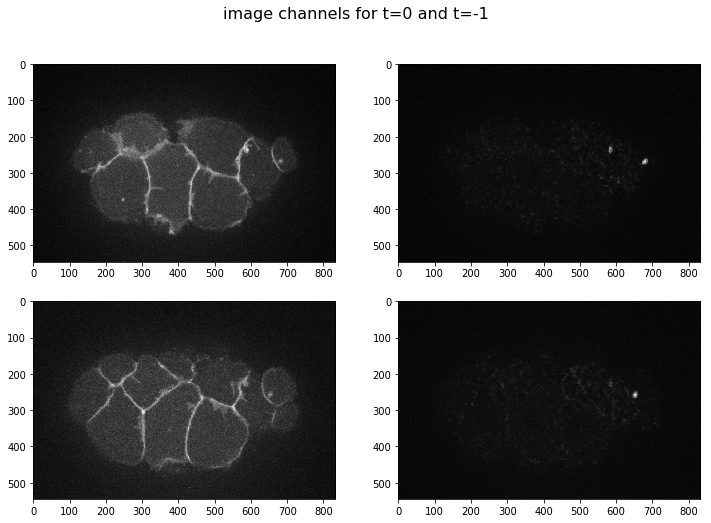

In [49]:
pylab.rcParams['figure.figsize'] = (12, 8)
fig = plt.figure()
fig.suptitle('image channels for t=0 and t=-1', fontsize=16)
ax = fig.add_subplot(221)
ax.imshow(segchannel[0], plt.get_cmap('gray'))
ax = fig.add_subplot(222)
ax.imshow(flowchannel[0], plt.get_cmap('gray'))
ax = fig.add_subplot(223)
ax.imshow(segchannel[-1], plt.get_cmap('gray'))
ax = fig.add_subplot(224)
ax.imshow(flowchannel[-1], plt.get_cmap('gray'))

In [50]:
flows = bsu.compute_flow( flowchannel )
flow_x, flow_y = bsu.split_flow_components( flows )

............................................................. ...done!


In [51]:
avg_flow_x = bsu.flow_average(flow_x, 5)
avg_flow_y = bsu.flow_average(flow_y, 5)

In [52]:
print(flow_x.shape)

(61, 545, 833)


In [53]:
# defining min and max radius for cell segmentation
max_rs = ((segchannel[0].shape[1] / 4),
          (segchannel[0].shape[1] / 4))

min_rs = (5,5)
print (min_rs, max_rs)

((5, 5), (208, 208))


In [54]:
data = Data3d( segchannel_smooth, pixelsize=(1.,1.), silent=False )
data.set_seg_params(num_columns=72,K=100,max_delta_k=4)
objects = []

In [60]:
cell_Ea = data.init_object("Ea")
objects.append(cell_Ea)
data.add_object_at( cell_Ea, min_rs, max_rs, frame=0, seed=(520,200), segment_it=True )

#Finding center in each frame
moving_center = data.track(cell_Ea, seed_frame=0, target_frames=range(1,len(data.images)), recenter_iterations=1)
moving_center.insert(0, [520,200]) # Adds the first seed to list of centers

('Added appearance for "Ea" in frame', 0, 'with seed coordinates', array([520., 200.]))
('      Optimum energy: ', 0.06526122106526644)
('      Nodes in/out: ', 2388, 4812)
('      Area: ', 17662.0)
('Added appearance for "Ea" in frame', 1, 'with seed coordinates', array([520., 200.]))
('      Optimum energy: ', 0.07546817741523937)
('      Nodes in/out: ', 2281, 4919)
('      Area: ', 17461.000000000004)
('    Updated center to', array([508, 220]))
('Added appearance for "Ea" in frame', 2, 'with seed coordinates', array([508., 220.]))
('      Optimum energy: ', 0.0801718702773831)
('      Nodes in/out: ', 2525, 4675)
('      Area: ', 17306.499999999993)
('    Updated center to', array([504, 225]))
('Added appearance for "Ea" in frame', 3, 'with seed coordinates', array([504., 225.]))
('      Optimum energy: ', 0.08649929754494692)
('      Nodes in/out: ', 2608, 4592)
('      Area: ', 17958.999999999996)
('    Updated center to', array([504, 225]))
('Added appearance for "Ea" in frame'

('      Optimum energy: ', 0.08045542709831491)
('      Nodes in/out: ', 1455, 5745)
('      Area: ', 6177.499999999997)
('    Updated center to', array([528, 251]))
('Added appearance for "Ea" in frame', 36, 'with seed coordinates', array([528., 251.]))
('      Optimum energy: ', 0.08167693041657417)
('      Nodes in/out: ', 1644, 5556)
('      Area: ', 7664.9999999999945)
('    Updated center to', array([523, 246]))
('Added appearance for "Ea" in frame', 37, 'with seed coordinates', array([523., 246.]))
('      Optimum energy: ', 0.07737928355270443)
('      Nodes in/out: ', 1666, 5534)
('      Area: ', 7766.999999999998)
('    Updated center to', array([520, 243]))
('Added appearance for "Ea" in frame', 38, 'with seed coordinates', array([520., 243.]))
('      Optimum energy: ', 0.07742716085658817)
('      Nodes in/out: ', 1532, 5668)
('      Area: ', 6971.499999999998)
('    Updated center to', array([518, 244]))
('Added appearance for "Ea" in frame', 39, 'with seed coordinates', 

In [61]:
cell_Ep = data.init_object("Ep")
objects.append(cell_Ep)
data.add_object_at( cell_Ep, min_rs, max_rs, frame=0, seed=(620,275), segment_it=True )

#Finding center in each frame
moving_center = data.track(cell_Ep, seed_frame=0, target_frames=range(1,len(data.images)), recenter_iterations=1)
moving_center.insert(0, [620,275]) # Adds the first seed to list of centers

('Added appearance for "Ep" in frame', 0, 'with seed coordinates', array([620., 275.]))
('      Optimum energy: ', 0.06729978617301284)
('      Nodes in/out: ', 2008, 5192)
('      Area: ', 11011.499999999996)
('Added appearance for "Ep" in frame', 1, 'with seed coordinates', array([620., 275.]))
('      Optimum energy: ', 0.06967482858598124)
('      Nodes in/out: ', 2013, 5187)
('      Area: ', 11099.499999999998)
('    Updated center to', array([615, 281]))
('Added appearance for "Ep" in frame', 2, 'with seed coordinates', array([615., 281.]))
('      Optimum energy: ', 0.07445324429038945)
('      Nodes in/out: ', 2010, 5190)
('      Area: ', 10905.999999999998)
('    Updated center to', array([613, 283]))
('Added appearance for "Ep" in frame', 3, 'with seed coordinates', array([613., 283.]))
('      Optimum energy: ', 0.07971904608074624)
('      Nodes in/out: ', 2009, 5191)
('      Area: ', 10835.49999999999)
('    Updated center to', array([613, 286]))
('Added appearance for "Ep

('      Optimum energy: ', 0.06235895247733341)
('      Nodes in/out: ', 1974, 5226)
('      Area: ', 10524.999999999996)
('    Updated center to', array([612, 274]))
('Added appearance for "Ep" in frame', 34, 'with seed coordinates', array([612., 274.]))
('      Optimum energy: ', 0.05977380189110672)
('      Nodes in/out: ', 2001, 5199)
('      Area: ', 10785.999999999998)
('    Updated center to', array([612, 274]))
('Added appearance for "Ep" in frame', 35, 'with seed coordinates', array([612., 274.]))
('      Optimum energy: ', 0.059895878815758585)
('      Nodes in/out: ', 1961, 5239)
('      Area: ', 10331.0)
('    Updated center to', array([612, 274]))
('Added appearance for "Ep" in frame', 36, 'with seed coordinates', array([612., 274.]))
('      Optimum energy: ', 0.060551995150705404)
('      Nodes in/out: ', 1914, 5286)
('      Area: ', 9899.500000000002)
('    Updated center to', array([610, 273]))
('Added appearance for "Ep" in frame', 37, 'with seed coordinates', array([

In [62]:
surface_coords_Ea, surface_coords_interior1_Ea, surface_coords_interior_last_Ea = data.segment2dt( cell_Ea, max_radial_delta=2 )

('Surface points:', [(596, 200), (591, 206), (586, 211), (583, 217), (581, 222), (579, 227), (580, 234), (572, 236), (572, 243), (573, 253), (574, 264), (572, 275), (569, 285), (564, 294), (552, 290), (543, 289), (534, 284), (527, 281), (520, 282), (513, 279), (506, 278), (499, 275), (493, 273), (487, 268), (481, 265), (477, 260), (475, 253), (473, 246), (472, 239), (467, 236), (459, 234), (452, 231), (450, 225), (444, 220), (445, 213), (436, 207), (427, 200), (424, 191), (425, 183), (430, 176), (437, 169), (436, 160), (443, 155), (452, 152), (453, 144), (456, 136), (467, 137), (477, 139), (487, 142), (495, 147), (503, 153), (508, 157), (512, 157), (516, 160), (520, 164), (523, 164), (524, 173), (526, 177), (527, 180), (531, 175), (537, 169), (543, 165), (548, 166), (549, 170), (554, 170), (562, 170), (571, 170), (581, 171), (591, 173), (601, 178), (600, 185), (599, 193)])
('Interior points:', [(577, 200), (573, 204), (568, 208), (566, 212), (564, 216), (563, 220), (564, 225), (557, 22

('Surface points:', [(570, 249), (570, 252), (567, 256), (567, 260), (565, 263), (566, 268), (564, 271), (564, 276), (563, 280), (561, 285), (560, 291), (559, 297), (556, 304), (551, 306), (545, 305), (539, 302), (533, 295), (528, 294), (525, 292), (521, 290), (517, 289), (513, 291), (510, 288), (506, 288), (504, 284), (500, 284), (494, 285), (492, 281), (485, 282), (476, 283), (466, 282), (467, 275), (466, 270), (473, 262), (470, 258), (467, 254), (465, 249), (461, 243), (454, 236), (457, 230), (464, 227), (467, 222), (467, 216), (477, 215), (482, 213), (487, 211), (491, 209), (498, 211), (504, 213), (510, 216), (512, 215), (515, 214), (519, 216), (522, 215), (525, 211), (528, 211), (531, 210), (535, 208), (541, 202), (549, 196), (557, 191), (567, 188), (577, 186), (581, 192), (581, 201), (578, 211), (575, 220), (573, 226), (575, 230), (574, 235), (571, 240), (572, 244)])
('Interior points:', [(552, 249), (552, 251), (549, 253), (549, 255), (548, 257), (549, 260), (548, 262), (549, 26

In [63]:
surface_coords_Ep, surface_coords_interior1_Ep, surface_coords_interior_last_Ep = data.segment2dt( cell_Ep, max_radial_delta=2 )

('Surface points:', [(665, 275), (669, 279), (672, 284), (675, 289), (676, 295), (674, 300), (671, 304), (665, 306), (656, 305), (647, 302), (646, 306), (647, 314), (644, 318), (643, 325), (641, 335), (638, 344), (633, 353), (627, 362), (620, 367), (611, 368), (602, 371), (596, 362), (591, 352), (587, 343), (582, 339), (581, 330), (576, 327), (571, 323), (569, 317), (567, 311), (566, 305), (567, 299), (567, 294), (570, 288), (571, 283), (570, 279), (568, 275), (568, 270), (569, 266), (568, 261), (569, 256), (571, 252), (571, 247), (574, 243), (575, 237), (580, 235), (584, 232), (586, 227), (588, 219), (591, 213), (596, 211), (601, 207), (608, 212), (615, 219), (620, 227), (623, 235), (626, 238), (631, 230), (636, 230), (640, 231), (645, 230), (653, 227), (654, 233), (655, 239), (654, 245), (655, 250), (655, 254), (657, 257), (659, 260), (660, 264), (660, 267), (663, 271)])
('Interior points:', [(647, 275), (651, 277), (654, 281), (658, 285), (659, 289), (657, 292), (655, 295), (650, 29

('Surface points:', [(656, 271), (658, 274), (661, 279), (668, 285), (673, 292), (678, 301), (675, 306), (673, 313), (672, 321), (669, 327), (661, 329), (653, 328), (643, 324), (635, 319), (628, 313), (622, 307), (619, 309), (617, 318), (613, 320), (607, 328), (601, 335), (593, 342), (589, 334), (586, 328), (583, 322), (578, 319), (575, 315), (573, 310), (568, 308), (560, 307), (557, 302), (562, 294), (564, 288), (566, 283), (568, 278), (569, 274), (569, 271), (571, 267), (574, 264), (572, 260), (573, 256), (575, 253), (575, 249), (575, 244), (576, 240), (577, 235), (578, 229), (577, 220), (578, 210), (580, 200), (584, 191), (592, 193), (600, 200), (607, 207), (613, 209), (618, 207), (623, 210), (629, 211), (632, 216), (640, 211), (643, 217), (646, 223), (646, 231), (646, 237), (647, 241), (648, 246), (650, 249), (652, 252), (652, 256), (651, 260), (651, 264), (654, 267)])
('Interior points:', [(638, 271), (640, 273), (643, 276), (651, 281), (655, 286), (661, 293), (659, 297), (658, 30

ValueError: 'vertices' must be a 2D list or array with shape Nx2

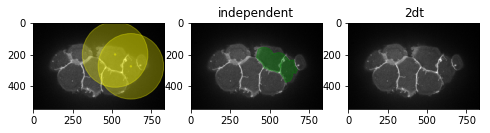

In [64]:
pylab.rcParams['figure.figsize'] = (8, 10)
for frame in range(1,len(data.images),len(data.images)/5):
    fig = plt.figure()
    ax = plt.subplot(131)
    data.plot_minmax( frame, ax )
    ax = plt.subplot(132)
    ax.set_title('independent')
    data.plot_result( frame, ax )    
    ax = plt.subplot(133)
    ax.set_title('2dt')
    data.plot_2dt_result( frame, ax )